In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
from nltk.translate.bleu_score import corpus_bleu
from nltk.util import ngrams
import numpy as np
from PIL import Image
import configparser

config = configparser.ConfigParser()
config.read("config.ini")

#importing local module 
from models.subclasses import *
from models.utilities import *
from models.predict import *
from models.train_utils import *


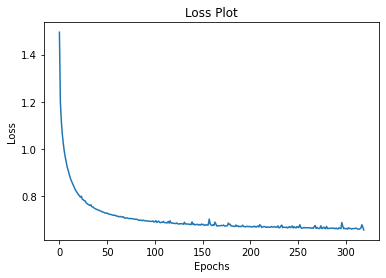

In [2]:
loss_plot = load_loss()
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [3]:
units = int(config['config']['units'])
embedding_dim = int(config['config']['embedding_dim'])
use_glove = bool(config['config']['use_glove'])

In [4]:
val_image_paths, image_path_to_caption = import_files(shuffle= False, method = "val")

val_captions = []
img_name_vector = []
for image_path in val_image_paths:
  caption_list = image_path_to_caption[image_path]
  val_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

500


In [5]:
train_image_paths, image_path_to_caption_train = import_files(shuffle= False, method = "train")

train_captions = []
img_name_vector_train = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption_train[image_path]
  train_captions.extend(caption_list)
  img_name_vector_train.extend([image_path] * len(caption_list))

30000


In [6]:
_, _, vocabulary, _ = load_dataset()

In [7]:
word_to_index_val, index_to_word_val, tokenizer_val, cap_vector_val = tokenization(val_captions, max_length, 5000)

In [8]:
word_to_index_train, index_to_word_train, tokenizer_train, cap_vector_train = tokenization(train_captions, max_length, 400000)

In [9]:
embeddings_index = {}

if use_glove:
    glove_path = "./dataset/glove.6B/glove.6B.50d.txt"

    
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    vocabulary = tokenizer_train.get_vocabulary()
    word_index = dict(zip(vocabulary, range(len(vocabulary))))

    num_tokens = len(vocabulary) + 2
    embedding_dim = 50
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13252 words (9975 misses)


In [10]:
encoder = CNN_Encoder(embedding_dim)
if use_glove:
    decoder = RNN_Decoder(embedding_dim, units, num_tokens, embedding_matrix)
else:
    decoder = RNN_Decoder(embedding_dim, units, tokenizer_train.vocabulary_size(), None)
image_features_extract_model = get_feature_extractor()

In [11]:
img_name_val, cap_val = split_data(img_name_vector, cap_vector_val ,
                                    image_features_extract_model, 1)

100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


In [12]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

In [60]:
references = []

for i in range(len(img_name_val)):
    references.append(' '.join([tf.compat.as_text(index_to_word_val(i).numpy())
                         for i in cap_val[i] if i not in [0]]).split('<start>')[1].split('<end>')[0])

In [63]:
list_of_references = []

for i in range(0, len(img_name_val), 5):
    list_of_references.append(references[i:i+5])

In [66]:
list_of_references[2]

[' an image of a night scene with a cat on top of a car ',
 ' night picture of a car parked and some parking lights in the distance. ',
 ' a car sitting on a car with a wall in the background. ',
 ' a cat sitting on top of a car at night time. ',
 ' a cat sitting on a car parked outside a building at night. ']

Real Caption:  a person wearing a suit and tie next to a couch 
Prediction Caption: a professional tennis player poses with a box.
BLEU-1: 0.292050
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


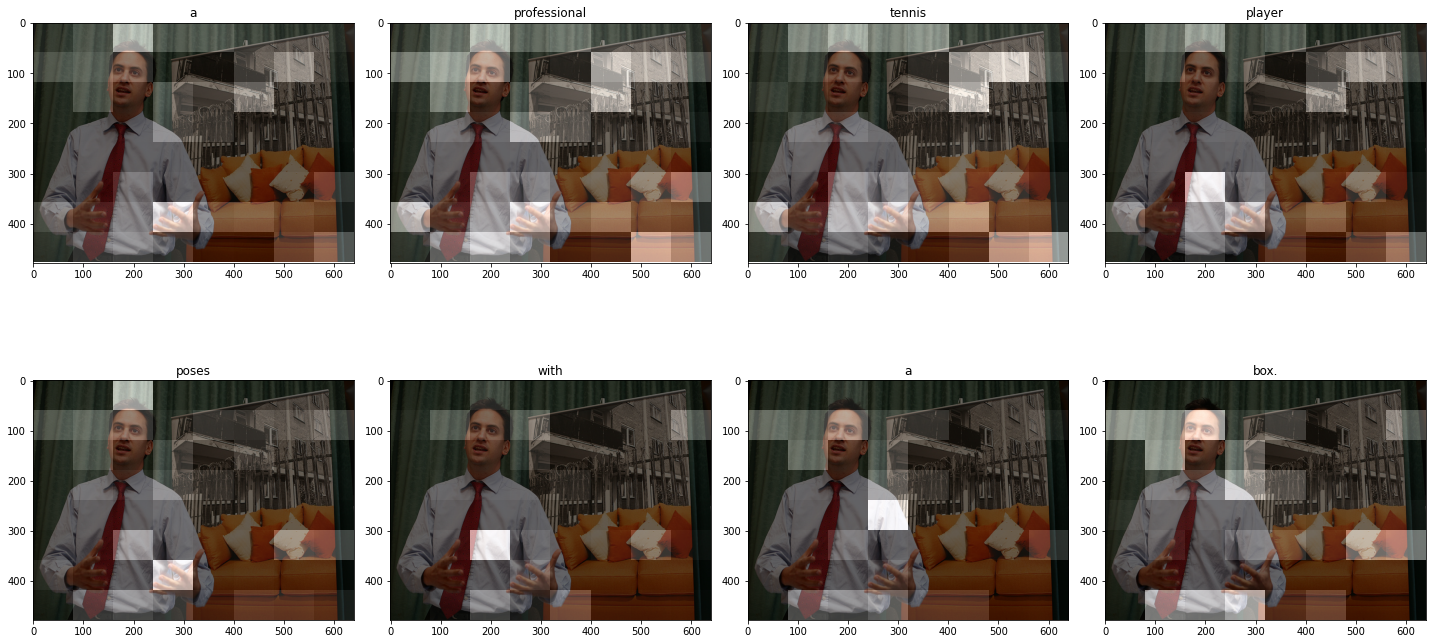

In [84]:
# captions on the test set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]

num = 3
test_references = []
for i in range(5):
   test_references.append(list_of_references[num][i].split())

image = img_name_val[num*5]
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]]).split()

result, attention_plot = evaluate(image, encoder, decoder, image_features_extract_model,
                                    word_to_index_train, index_to_word_train)

if result[-1] == "<end>":
    result.remove("<end>")

# if real_caption[0] == "<start>":
#     real_caption.remove("<start>")


list_of_hypotheses = [result]

print('Real Caption:', list_of_references[num][0])
print('Prediction Caption:', ' '.join(result))
print('BLEU-1: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu([test_references], list_of_hypotheses, weights=(0.25, 0.25, 0.25, 0.25)))
plot_attention(image, result, attention_plot)